In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
from collections import defaultdict

import rasterio
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report

from geospatial.visualization.raster_label_visualizer import RasterLabelVisualizer

# Evaluation against 2019-2020/04 verified labels

WCS Colombia corrected the coarse category model's output in seven randomly selected windows. Here we evaluate the model's outputs (different versions: after applying a majority filter) against these labels.

Note that when the manual correction was carried out, most sandy area near rivers were eliminated even if sandy areas are visible from the 2019-2020 Landsat8 composite image.

The verified polygons are first rasterized using GDAL. The rasterized versions are in the `labels_dir` directory specified below.

### Micro and macro averages

The "micro" averages are metrics calculated globally by counting the total true positives, false negatives and false positives.

The "macro" averages are the unweighted mean across each label, for the metrics calculated for each label.

We do not use a weighting among the categories, so the "weighted" average is the same as the "micro" average.

In [3]:
labels_dir = '/Users/siyuyang/Data/WCSColombia/provided_labels/Landuse_corrections_Felipe/results_corrected_raster'

# raw output
model_outputs_raw_path = '/Users/siyuyang/Data/WCSColombia/delivered/20201221_timepoints/2019_202004/res_wcs_orinoquia_sr_median_2019_202004.vrt'

# majority filter radius 3
model_outputs_filtered3_path = '/Users/siyuyang/Data/WCSColombia/delivered/20200715/results_coarse_baseline_201920_filtered3/po_res_wcs_orinoquia_sr_median_2019_202004.vrt'

model_outputs_filtered5_path = '/Users/siyuyang/Data/WCSColombia/delivered/20200715/results_coarse_baseline_201920_filtered5/po_res_wcs_orinoquia_sr_median_2019_202004.vrt'

model_outputs_filtered7_path = '/Users/siyuyang/Data/WCSColombia/delivered/20200715/results_coarse_baseline_201920_filtered7/po_res_wcs_orinoquia_sr_median_2019_202004.vrt'

In [4]:
viz = RasterLabelVisualizer('../constants/class_lists/wcs_coarse_label_map.json')

In [5]:
with open('../constants/class_lists/wcs_coarse_label_map.json') as f:
    label_map = json.load(f)

In [6]:
labels = [int(i) for i in label_map['num_to_name'].keys() if i not in ['0', '9']]  # exclude "Empty of data" and label "Unavailable" categories
target_names = [label_map['num_to_name'][str(i)] for i in labels]

In [7]:
def evaluate_label_windows(model_outputs_path, visualize=True):

    results = {}
    
    model_outputs_reader = rasterio.open(model_outputs_path)

    # for overall across all tiles
    y_true = []
    y_pred = []

    for label_f in tqdm(os.listdir(labels_dir)):
        if not label_f.endswith('.tif'):
            continue

        window_name = label_f.split('.tif')[0]
        results[window_name] = {}

        label_tile_reader = rasterio.open(os.path.join(labels_dir, label_f))

        # get the window to crop the corresponding scene from the big (vrt) model outputs raster
        x_min = label_tile_reader.bounds.left
        y_min = label_tile_reader.bounds.top  # origin is left, top

        # getting the pixel array indices corresponding to points in georeferenced space
        row, col = model_outputs_reader.index(x_min, y_min)

        row_end = row + label_tile_reader.height  # both rasters have the same resolution
        col_end = col + label_tile_reader.width 

        w = rasterio.windows.Window.from_slices((row, row_end), (col, col_end))

        model_output_tile = model_outputs_reader.read(1, window=w)
        label_tile = label_tile_reader.read(1)

        if visualize:
            im, buf = viz.show_label_raster(model_output_tile, (12, 7))
            results[window_name]['model_output_tile'] = im
            im, buf = viz.show_label_raster(label_tile, (12, 7))
            results[window_name]['label_tile'] = im

        assert model_output_tile.shape == label_tile.shape
        report = classification_report(label_tile.flatten(), model_output_tile.flatten(),
                                       labels=labels, target_names=target_names,
                                       zero_division=0)
        results[window_name]['report'] = report
        
        y_true.extend(label_tile.flatten())
        y_pred.extend(model_output_tile.flatten())

    print('Calculating overall metrics...')
    overall_report = classification_report(y_true, y_pred, labels=labels, target_names=target_names)
    
    return results, overall_report

## Evaluating model outputs (raw)

No filtering

In [8]:
results, overall_report = evaluate_label_windows(model_outputs_raw_path)

100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Calculating overall metrics...


Evaluating window_1
Model output:


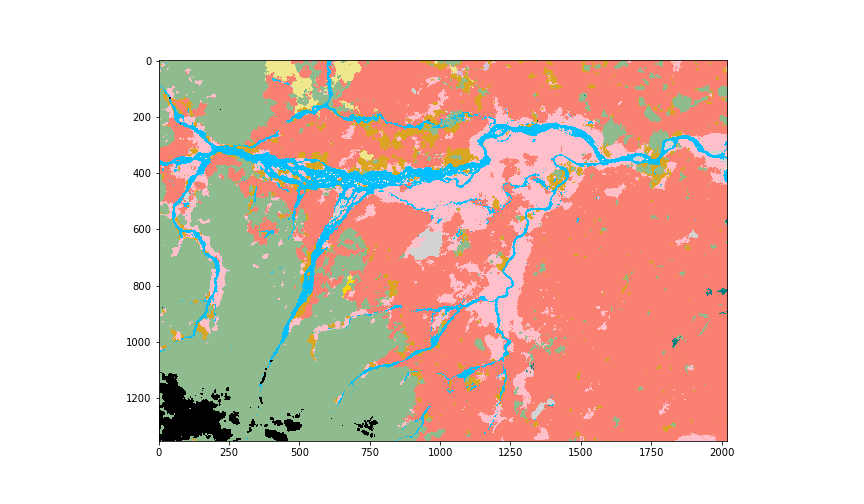

Labels after correction:


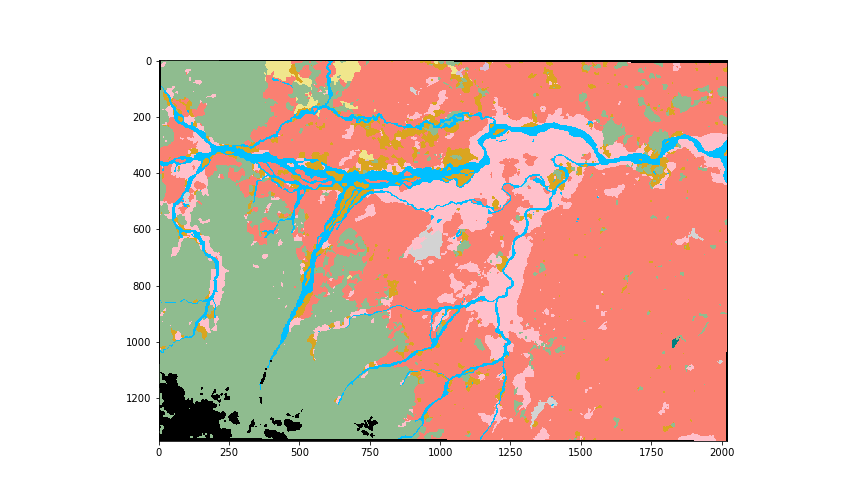

                             precision    recall  f1-score   support

   Urban and infrastructure       0.61      0.81      0.70     13276
                Agriculture       0.89      0.93      0.91    298257
Arboreal and forestry crops       0.24      0.92      0.38       504
                    Pasture       0.97      0.97      0.97   1364995
                 Vegetation       0.82      0.74      0.78    115579
                     Forest       0.96      0.98      0.97    689297
                    Savanna       0.00      0.00      0.00         0
  Sand, rocks and bare land       0.00      0.00      0.00         0
                      Swamp       0.00      0.00      0.00         0
                      Water       0.84      0.85      0.84    153843
           Seasonal savanna       0.75      0.93      0.83     16833
 Seasonally flooded savanna       0.65      0.78      0.71      1213

                  micro avg       0.94      0.95      0.94   2653797
                  macro avg     

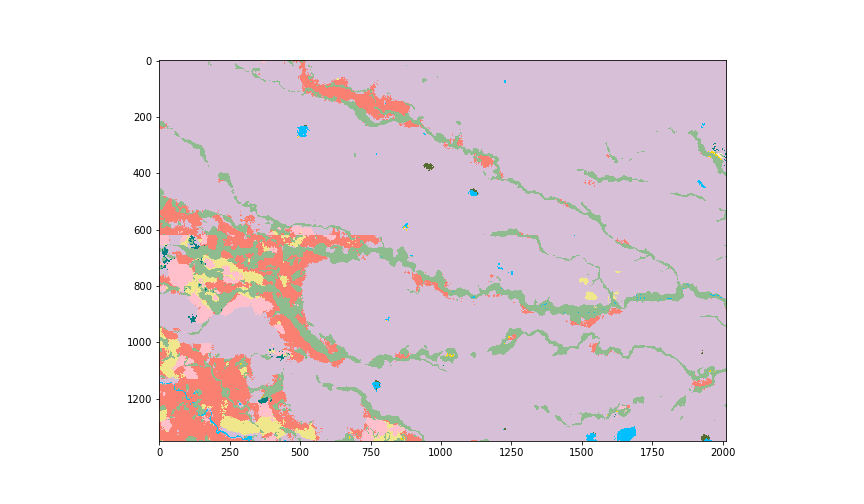

Labels after correction:


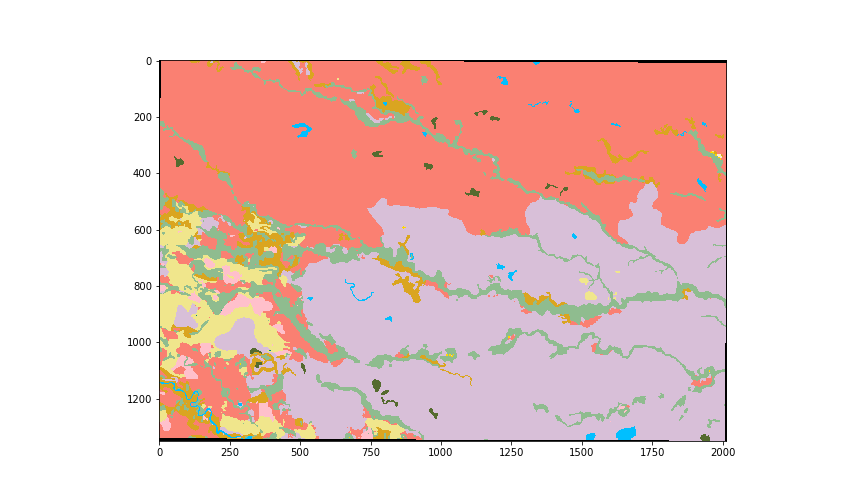

                             precision    recall  f1-score   support

   Urban and infrastructure       0.00      0.00      0.00         0
                Agriculture       0.50      0.91      0.65     26137
Arboreal and forestry crops       0.01      0.63      0.02        60
                    Pasture       0.68      0.12      0.21   1166879
                 Vegetation       0.77      0.00      0.00     91744
                     Forest       0.94      0.89      0.91    241676
                    Savanna       0.46      0.79      0.58       591
  Sand, rocks and bare land       0.75      0.82      0.78       188
                      Swamp       0.79      0.13      0.22      9342
                      Water       0.66      0.49      0.56     13413
           Seasonal savanna       0.82      0.34      0.48    105051
 Seasonally flooded savanna       0.47      0.99      0.64   1035476

                  micro avg       0.53      0.54      0.54   2690557
                  macro avg     

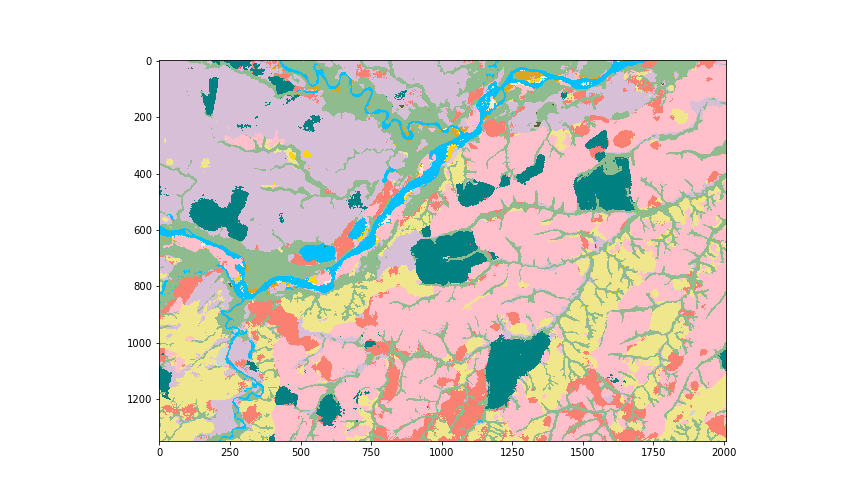

Labels after correction:


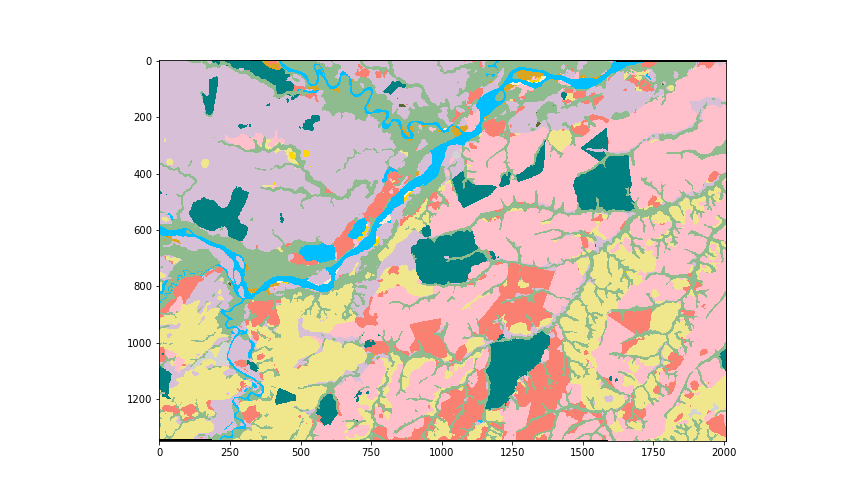

                             precision    recall  f1-score   support

   Urban and infrastructure       0.93      0.44      0.59      6102
                Agriculture       0.78      0.93      0.85    658161
Arboreal and forestry crops       0.92      0.90      0.91    180212
                    Pasture       0.66      0.54      0.60    229599
                 Vegetation       0.77      0.74      0.75     10096
                     Forest       0.92      0.92      0.92    491817
                    Savanna       0.41      0.82      0.55      3076
  Sand, rocks and bare land       0.32      0.75      0.45      2374
                      Swamp       0.69      0.62      0.65       637
                      Water       0.90      0.90      0.90     91188
           Seasonal savanna       0.82      0.72      0.76    421437
 Seasonally flooded savanna       0.93      0.90      0.91    593648

                  micro avg       0.84      0.85      0.85   2688347
                  macro avg     

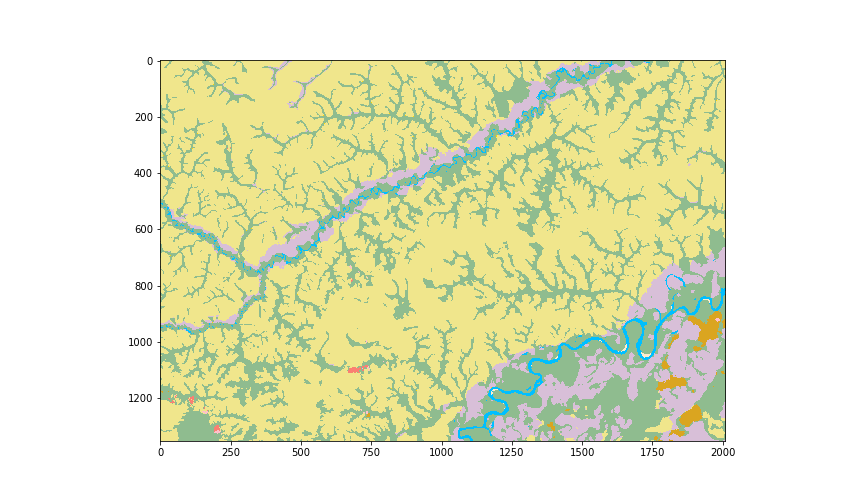

Labels after correction:


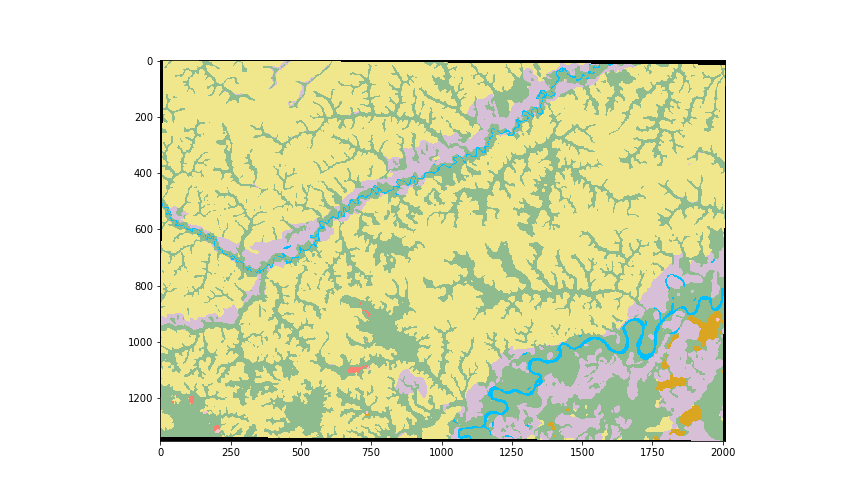

                             precision    recall  f1-score   support

   Urban and infrastructure       0.00      0.00      0.00         0
                Agriculture       0.65      0.81      0.72       904
Arboreal and forestry crops       0.00      0.00      0.00         0
                    Pasture       0.83      0.72      0.77      2401
                 Vegetation       0.93      0.95      0.94     18131
                     Forest       0.91      0.86      0.89    785706
                    Savanna       0.01      0.86      0.03         7
  Sand, rocks and bare land       0.00      1.00      0.01         3
                      Swamp       0.00      0.00      0.00         0
                      Water       0.85      0.79      0.82     36741
           Seasonal savanna       0.90      0.98      0.94   1562505
 Seasonally flooded savanna       0.93      0.80      0.86    264971

                  micro avg       0.91      0.92      0.91   2671369
                  macro avg     

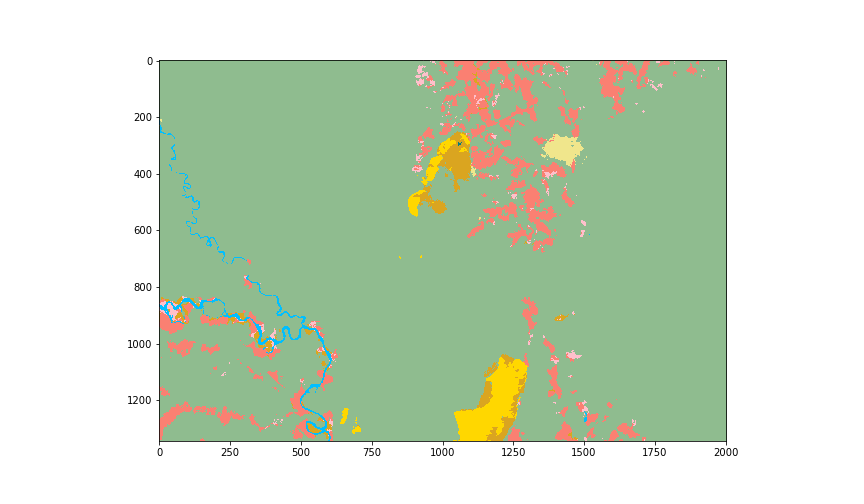

Labels after correction:


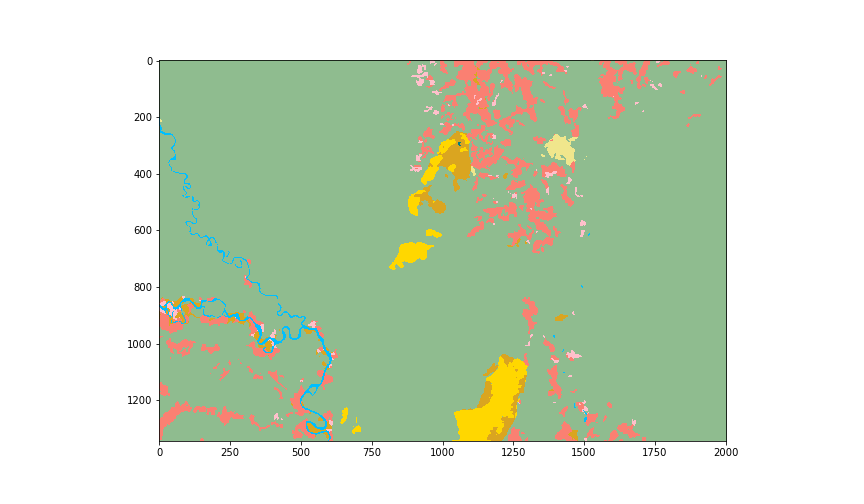

                             precision    recall  f1-score   support

   Urban and infrastructure       0.00      0.00      0.00         0
                Agriculture       0.73      0.73      0.73     16342
Arboreal and forestry crops       0.62      0.69      0.65       118
                    Pasture       0.94      0.90      0.92    171441
                 Vegetation       0.89      0.85      0.87     40663
                     Forest       0.98      0.99      0.99   2375951
                    Savanna       0.97      0.80      0.88     54037
  Sand, rocks and bare land       0.00      0.00      0.00         0
                      Swamp       0.00      0.00      0.00         0
                      Water       0.86      0.85      0.85     19764
           Seasonal savanna       0.73      0.97      0.83      7806
 Seasonally flooded savanna       0.00      0.00      0.00         0

                  micro avg       0.98      0.98      0.98   2686122
                  macro avg     

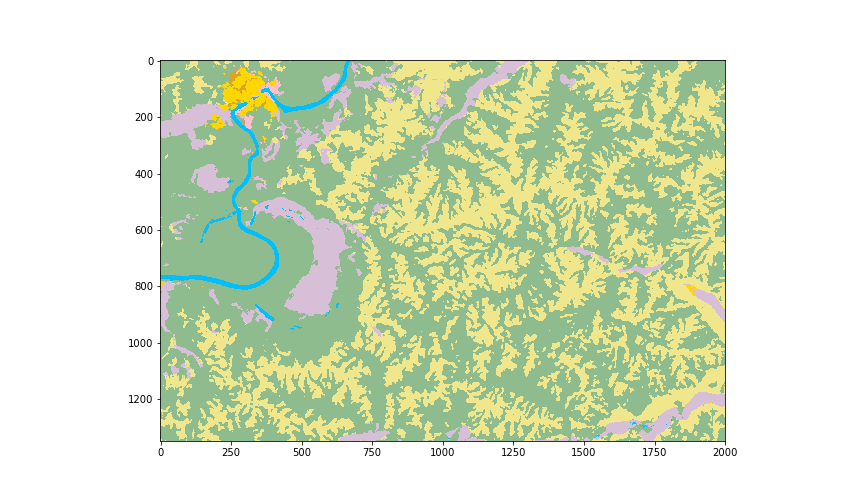

Labels after correction:


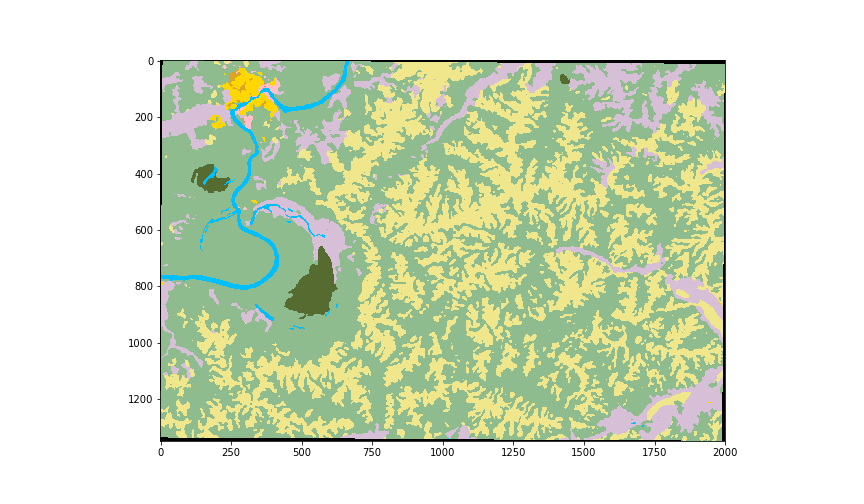

                             precision    recall  f1-score   support

   Urban and infrastructure       0.00      0.00      0.00         0
                Agriculture       0.87      0.89      0.88      4509
Arboreal and forestry crops       0.00      0.00      0.00         0
                    Pasture       0.37      0.75      0.50       171
                 Vegetation       0.80      0.89      0.85      2388
                     Forest       0.96      0.97      0.97   1525497
                    Savanna       0.83      0.94      0.88     17500
  Sand, rocks and bare land       0.00      0.00      0.00         0
                      Swamp       0.00      0.00      0.00     33090
                      Water       0.94      0.85      0.89     31522
           Seasonal savanna       0.83      0.96      0.89    790304
 Seasonally flooded savanna       0.73      0.52      0.61    251664

                  micro avg       0.90      0.91      0.91   2656645
                  macro avg     

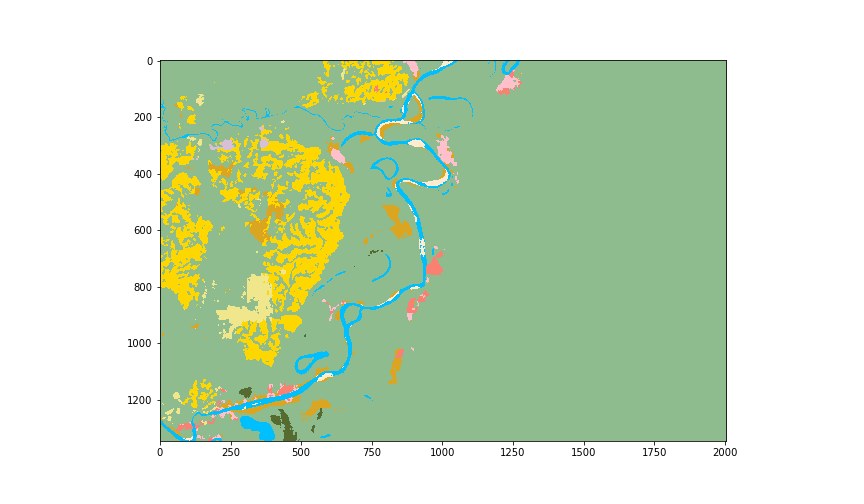

Labels after correction:


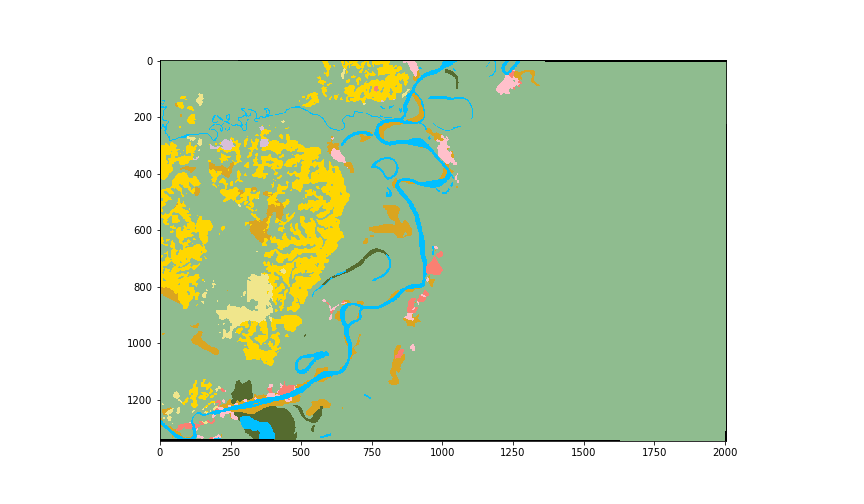

                             precision    recall  f1-score   support

   Urban and infrastructure       0.00      0.00      0.00         0
                Agriculture       0.90      0.85      0.87     15462
Arboreal and forestry crops       0.00      0.00      0.00         0
                    Pasture       0.85      0.93      0.89     11022
                 Vegetation       0.91      0.66      0.76     56241
                     Forest       0.97      0.99      0.98   2283609
                    Savanna       0.94      0.95      0.95    191594
  Sand, rocks and bare land       0.00      0.00      0.00         0
                      Swamp       0.95      0.27      0.42     24030
                      Water       0.92      0.79      0.85     66739
           Seasonal savanna       0.92      0.94      0.93     24502
 Seasonally flooded savanna       0.89      0.93      0.91      2888

                  micro avg       0.96      0.97      0.97   2676087
                  macro avg     

In [9]:
for window_name, res in results.items():
    print(f'Evaluating {window_name}')
    
    print('Model output:')
    res['model_output_tile']
    
    print('Labels after correction:')
    res['label_tile']
    
    print(res['report'])
    print('----------------------------------------------')
    print()
    print()

print('Overall report:')    
print(overall_report)

## Evaluating model outputs with majority filter radius 3 applied

In [10]:
results3, overall_report3 = evaluate_label_windows(model_outputs_filtered3_path)

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Calculating overall metrics...


In [11]:
print('Overall report for majority filter radius 3:') 
print(overall_report3)

Overall report for majority filter radius 3:
                             precision    recall  f1-score   support

   Urban and infrastructure       0.67      0.69      0.68     19378
                Agriculture       0.82      0.95      0.88   1019772
Arboreal and forestry crops       0.91      0.91      0.91    180894
                    Pasture       0.92      0.61      0.73   2946508
                 Vegetation       0.93      0.58      0.71    334842
                     Forest       0.97      0.97      0.97   8393553
                    Savanna       0.94      0.93      0.94    266805
  Sand, rocks and bare land       0.15      0.85      0.25      2565
                      Swamp       0.95      0.12      0.21     67099
                      Water       0.88      0.84      0.86    413210
           Seasonal savanna       0.87      0.92      0.90   2928438
 Seasonally flooded savanna       0.61      0.89      0.72   2149860

                  micro avg       0.87      0.88      0.

## Evaluating model outputs with majority filter radius 5 applied

In [12]:
results5, overall_report5 = evaluate_label_windows(model_outputs_filtered5_path)

100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


Calculating overall metrics...


In [13]:
print('Overall report for majority filter radius 5:')  
print(overall_report5)

Overall report for majority filter radius 5:
                             precision    recall  f1-score   support

   Urban and infrastructure       0.68      0.69      0.68     19378
                Agriculture       0.81      0.94      0.87   1019772
Arboreal and forestry crops       0.91      0.91      0.91    180894
                    Pasture       0.91      0.60      0.73   2946508
                 Vegetation       0.93      0.55      0.70    334842
                     Forest       0.96      0.97      0.97   8393553
                    Savanna       0.94      0.92      0.93    266805
  Sand, rocks and bare land       0.14      0.75      0.24      2565
                      Swamp       0.96      0.12      0.21     67099
                      Water       0.87      0.81      0.84    413210
           Seasonal savanna       0.87      0.92      0.89   2928438
 Seasonally flooded savanna       0.60      0.89      0.72   2149860

                  micro avg       0.87      0.88      0.

## Evaluating model outputs with majority filter radius 7 applied

In [14]:
results7, overall_report7 = evaluate_label_windows(model_outputs_filtered7_path)

100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Calculating overall metrics...


In [15]:
print('Overall report for majority filter radius 7:')  
print(overall_report7)

Overall report for majority filter radius 7:
                             precision    recall  f1-score   support

   Urban and infrastructure       0.69      0.68      0.68     19378
                Agriculture       0.80      0.93      0.86   1019772
Arboreal and forestry crops       0.91      0.90      0.91    180894
                    Pasture       0.90      0.60      0.72   2946508
                 Vegetation       0.92      0.52      0.67    334842
                     Forest       0.95      0.96      0.96   8393553
                    Savanna       0.92      0.90      0.91    266805
  Sand, rocks and bare land       0.13      0.64      0.22      2565
                      Swamp       0.96      0.11      0.20     67099
                      Water       0.86      0.78      0.82    413210
           Seasonal savanna       0.85      0.91      0.88   2928438
 Seasonally flooded savanna       0.60      0.88      0.72   2149860

                  micro avg       0.86      0.87      0.